# Brace-Gatarek-Musiela (BGM) model

The BGM model is a term structure model widely used in interest rate derivatives pricing, particularly for instruments like caps, floors, and swaptions. Unlike short-rate models (e.g., Vasicek, CIR), which model the instantaneous short rate, the BGM model directly models forward LIBOR rates, making it more aligned with market observables. Here’s a detailed breakdown:

#### 1. **Model Setup**
- **Forward LIBOR Rates**: The BGM model focuses on forward LIBOR rates $ L(t, T_i, T_{i+1}) $, which are the rates set at time $ t $ for the period $[T_i, T_{i+1}]$, typically with a fixed tenor (e.g., 3 months or 6 months). These rates are related to zero-coupon bond prices via:
  $$
  1 + \delta_i L(t, T_i, T_{i+1}) = \frac{P(t, T_i)}{P(t, T_{i+1})}
  $$
  where:
  - $ \delta_i = T_{i+1} - T_i $ is the tenor (e.g., 0.5 years for semi-annual periods).
  - $ P(t, T_i) $ is the price at time $ t $ of a zero-coupon bond maturing at $ T_i $.

- **Tenor Structure**: Define a tenor structure $ 0 = T_0 < T_1 < \cdots < T_N $, where $ T_i $ are the reset dates, and $ \delta_i = T_{i+1} - T_i $.

#### 2. **Dynamics of Forward Rates**
- In the BGM model, each forward LIBOR rate $ L(t, T_i, T_{i+1}) $ follows a lognormal process under its associated forward measure $ Q^{T_{i+1}} $:
  $$
  dL(t, T_i, T_{i+1}) = L(t, T_i, T_{i+1}) \sigma_i(t) dW_i^{T_{i+1}}(t)
  $$
  where:
  - $ \sigma_i(t) $ is the volatility of the forward rate, which can be time-dependent (often assumed piecewise constant for simplicity).
  - $ W_i^{T_{i+1}}(t) $ is a Brownian motion under the $ T_{i+1} $-forward measure.

- **Volatility Structure**: The volatilities \( \sigma_i(t) \) are typically specified as deterministic functions. A common choice is:
  $$
  \sigma_i(t) = \sigma_i \quad \text{(constant volatility for each forward rate)}
  $$
  or a more flexible form like:
  $$
  \sigma_i(t) = \sigma_i e^{-\kappa_i (T_i - t)}
  $$
  to allow volatility to decay as the reset date approaches.

- **Correlation**: The Brownian motions \( W_i^{T_{i+1}} \) for different forward rates are correlated, with a correlation matrix $ \rho_{ij} $. A common parameterization is:
  $$
  \rho_{ij} = e^{-\beta |T_i - T_j|}
  $$
  where $ \beta > 0 $ controls the decay of correlation between forward rates.

#### 3. **Measure Changes**
- The BGM model uses different forward measures for each forward rate, which simplifies pricing of instruments like caps and floors. To simulate the entire term structure under a single measure (e.g., the spot measure or terminal measure), you need to adjust the drifts using the Girsanov theorem.
- Under the spot measure $ Q $, the dynamics of $ L(t, T_i, T_{i+1}) $ include a drift term:
  $$
  dL(t, T_i, T_{i+1}) = L(t, T_i, T_{i+1}) \left( \sum_{j=\eta(t)}^i \frac{\delta_j L(t, T_j, T_{j+1}) \sigma_j(t) \sigma_i(t) \rho_{ij}}{1 + \delta_j L(t, T_j, T_{j+1})} dt + \sigma_i(t) dW_i(t) \right)
  $$
  where $ \eta(t) $ is the index of the next reset date after $ t $.

#### 4. **Zero-Coupon Bond Pricing**
- To price a zero-coupon bond \( P(t, T) \), you need the forward rates up to $ T $. The bond price is:
  $$
  P(t, T) = \prod_{i: T_i < T \leq T_{i+1}} \frac{1}{1 + \delta_i L(t, T_i, T_{i+1})}
  $$
  - At $ t = 0 $, you can use the initial forward rates $ L(0, T_i, T_{i+1}) $, which are derived from the observed yield curve (e.g., your STRIPS data).
  - The yield for maturity $ T $ is then:
    $$
    y(0, T) = -\frac{\ln P(0, T)}{T} \times 100 \quad (\text{in percentage})
    $$

#### 5. **Calibration**
- The BGM model is calibrated by fitting the initial forward rates \( L(0, T_i, T_{i+1}) \) and volatilities \( \sigma_i \) to market data:
  - **Forward Rates**: Extract \( L(0, T_i, T_{i+1}) \) from the observed yield curve (e.g., STRIPS yields).
  - **Volatilities**: Calibrate \( \sigma_i \) to match market prices of interest rate derivatives (e.g., caplets, swaptions) or, in your case, to fit the yield curve directly.
- In your context, since you’re fitting to STRIPS yields, you’ll adjust the volatilities and possibly the initial forward rates to minimize the difference between model-implied yields and observed yields.

#### 6. **Advantages and Limitations**
- **Advantages**:
  - Directly models market-observable forward rates, making it intuitive for pricing LIBOR-based derivatives.
  - Lognormal dynamics ensure positive forward rates, unlike Vasicek.
  - Flexible volatility and correlation structures allow better fit to market data.
- **Limitations**:
  - Complex drift adjustments when simulating under a single measure.
  - Assumes lognormal forward rates, which may not capture all yield curve dynamics (e.g., stochastic volatility).
  - Calibration can be computationally intensive, especially with many forward rates.



In [35]:
import pandas as pd
import numpy as np

## Data Preparation

- Parsing: We parse the CSV data into a pandas DataFrame.
- Latest Data: We select the row for February 4, 2025.
- Extract Columns: For each maturity, we extract the time to maturity, price, and yield.
- Arrays: Convert the extracted data into numpy arrays for further processing.

Output:
- maturities: Times to maturity (e.g., 0.030116 for Feb 2025, 0.273785 for May 2025, ..., 14.524298 for Aug 2039).
- prices: Prices of the STRIPS (e.g., 99.932 for Feb 2025, ..., 51.226 for Aug 2039).
- yields: Yields in decimal form (e.g., 0.0252 for Feb 2025, ..., 0.04658 for Aug 2039).

In [36]:
#Data Preparation
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

# Select the most recent date (2025-02-04)
latest_date = "2025-02-04"
latest_data = df[df['Date'] == latest_date].iloc[0]

# Extract times, prices, and yields
maturities = []
prices = []
yields = []

# There are 46 maturities, each with Price, Time, and Yield
for i in range(46):
    maturity_label = df.columns[1 + i*3].split('_')[1]  # e.g., 'Feb2025' from 'Price_Feb2025'
    time_col = f'Time_{maturity_label}'
    price_col = f'Price_{maturity_label}'
    yield_col = f'Yield_{maturity_label}'
    
    time = latest_data[time_col]
    price = latest_data[price_col]
    yield_val = latest_data[yield_col]
    
    maturities.append(time)
    prices.append(price)
    yields.append(yield_val)

# Convert to numpy arrays
maturities = np.array(maturities)
prices = np.array(prices)
yields = np.array(yields)

# Face value of STRIPS (assumed)
face_value = 100

# Verify data
print("Maturities:", maturities)
print("Prices:", prices)
print("Yields:", yields)

Maturities: [ 0.03011636  0.27378508  0.52566735  0.77754962  1.0294319   1.27310062
  1.52498289  1.77686516  2.02874743  2.27241615  2.52429843  2.7761807
  3.02806297  3.27446954  3.52635181  3.77823409  4.03011636  4.27378508
  4.52566735  5.27310062  5.52498289  5.77686516  6.02874743  6.27241615
  6.52429843  6.7761807   7.02806297  7.27446954  7.52635181  7.77823409
  8.03011636  8.27378508  8.52566735  8.77754962  9.0294319   9.27310062
  9.52498289  9.77686516 11.02806297 12.03011636 12.27378508 13.0294319
 13.27310062 14.02874743 14.27241615 14.52429843]
Prices: [99.932 98.863 97.544 96.805 95.935 94.82  94.007 93.401 92.335 90.939
 90.099 89.155 88.04  87.107 86.492 85.241 84.677 83.381 82.523 79.835
 78.817 78.023 77.122 76.167 75.256 74.384 73.557 72.766 71.9   71.245
 70.251 69.435 68.631 67.886 67.017 66.265 65.478 64.734 62.076 58.889
 58.016 55.667 55.083 52.863 51.926 51.226]
Yields: [0.0252  0.04204 0.03694 0.04243 0.04081 0.04221 0.04088 0.03887 0.03973
 0.04222 0.0

## Compute Initial Forward Rates

In [37]:
# Define tenor structure (semi-annual intervals)
delta = 0.5
max_maturity = maturities[-1]  # 14.524298
reset_times = np.arange(0, max_maturity + delta, delta)  # 0, 0.5, 1.0, ..., 14.5

# Interpolate bond prices at reset times
observed_prices = prices  # Already extracted

# Function to interpolate bond prices
def interpolate_price(t, maturities, prices):
    if t <= maturities[0]:
        return prices[0]
    if t >= maturities[-1]:
        return prices[-1]
    idx = np.searchsorted(maturities, t, side='left')
    if maturities[idx] == t:
        return prices[idx]
    # Linear interpolation
    t0, t1 = maturities[idx-1], maturities[idx]
    p0, p1 = prices[idx-1], prices[idx]
    return p0 + (p1 - p0) * (t - t0) / (t1 - t0)

# Compute initial forward rates
initial_forwards = []
for i in range(len(reset_times) - 1):
    T_i = reset_times[i]
    T_ip1 = reset_times[i + 1]
    P_i = interpolate_price(T_i, maturities, observed_prices)
    P_ip1 = interpolate_price(T_ip1, maturities, observed_prices)
    # Forward rate: (P(T_i) / P(T_{i+1}) - 1) / delta
    L = (P_i / P_ip1 - 1) / delta
    initial_forwards.append(max(L, 1e-6))  # Ensure positive forward rates

initial_forwards = np.array(initial_forwards)
print("Initial Forward Rates:", initial_forwards)

Initial Forward Rates: [0.04614307 0.0341901  0.04142989 0.03528084 0.05049079 0.04572846
 0.03715232 0.04276166 0.05166424 0.04437865 0.04813058 0.04384959
 0.04992973 0.04602208 0.04607652 0.04606384 0.04822727 0.04750963
 0.04766859 0.04033858 0.03361453 0.03418916 0.0515261  0.05392016
 0.05834631 0.05575106 0.04932686 0.05548672 0.06448881 0.00263644]


## BGM Model

In [38]:
class BGM:
    def __init__(self, times, initial_forwards, volatilities, delta=0.5):
        self.times = np.array(times)
        self.forwards = np.array(initial_forwards)  # Use a modifiable forwards array
        self.initial_forwards = np.array(initial_forwards)  # Keep the initial values for reference
        self.volatilities = np.array(volatilities)
        self.delta = delta
        self.N = len(times) - 1
    
    def zero(self, t0, T):
        if T <= self.times[0]:
            return 1.0
        idx = np.searchsorted(self.times, T, side='left') - 1
        if idx < 0:
            idx = 0
        price = 1.0
        for i in range(idx + 1):
            if i < self.N:
                price /= (1 + self.delta * self.forwards[i])
        if idx + 1 < len(self.times) and self.times[idx + 1] > T:
            fraction = (self.times[idx + 1] - T) / self.delta
            price *= (1 + self.delta * self.forwards[idx]) ** fraction
        return max(price, 1e-10)
    
    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau)
        return -np.log(p) / tau * 100
    
    def update_params(self, x):
        self.forwards = np.maximum(x, 1e-6)  # Update forwards, ensure they’re positive

In [39]:
import matplotlib.pyplot as plt

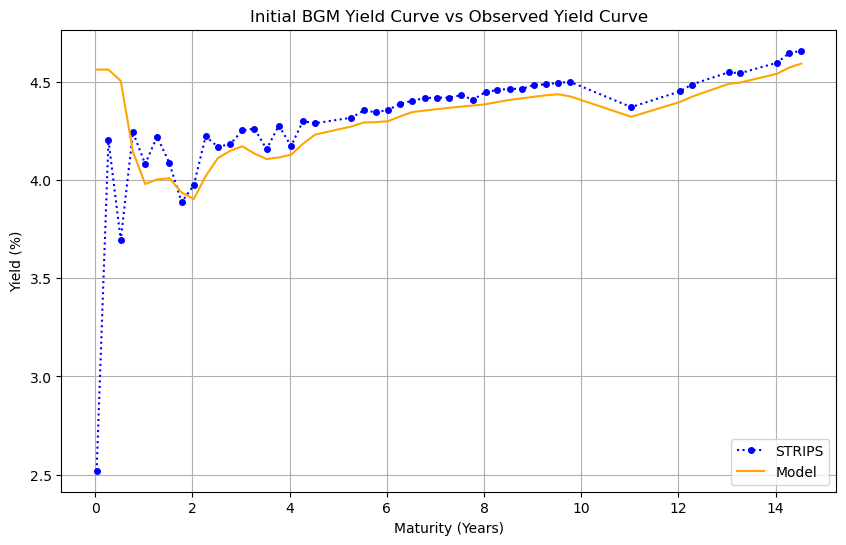

In [40]:
# Initialize the model
# Step 5: Initialize and Fit Model
initial_volatilities = np.ones(len(initial_forwards)) * 0.2  # Fixed at 20%, not used for yield curve
bgm = BGM(reset_times, initial_forwards, initial_volatilities, delta)

# Initial yield curve plot
initial_model_yields = [bgm.yield_curve(t) for t in maturities]
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, label='STRIPS', linestyle='dotted', marker='o', color='blue', markersize=4)
plt.plot(maturities, initial_model_yields, label='Model', linestyle='solid', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Initial BGM Yield Curve vs Observed Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


## Define the Fitter Class

In [41]:
from scipy.optimize import least_squares

class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields) * 100
        self.times = np.array(obs_times)
        self.dist = dist
        self.model_yields = None
        self.n_params = len(model.forwards)  # Number of parameters (forward rates)

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = np.array([m.yield_curve(t) for t in self.times])
        return model_yields - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)
        ss_res = np.sum((self.data - self.model_yields) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)
        rss = np.sum((self.data - self.model_yields) ** 2)
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        bounds = ([0] * len(x0), [1.0] * len(x0))  # Forward rates between 0 and 1
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])
        return result

Optimized forward rates: [3.48892034e-02 5.18631936e-02 3.70375381e-02 3.51824639e-02
 5.44595324e-02 4.35949674e-02 4.09215603e-02 4.30833600e-02
 5.08505247e-02 3.93938270e-02 5.28391179e-02 4.39304190e-02
 5.12825718e-02 4.65085353e-02 4.46875071e-02 4.74680137e-02
 4.95643383e-02 4.75893606e-02 4.87034443e-02 4.69414995e-02
 3.03895012e-02 3.08315036e-02 5.21919058e-02 5.52227061e-02
 6.31151893e-02 5.40066845e-02 4.37732717e-02 6.20171742e-02
 6.84507947e-02 6.80467401e-08]
R-squared: 0.6750887015822531
RMSE (%): 0.18536950110413192
AIC: -95.05718111887612


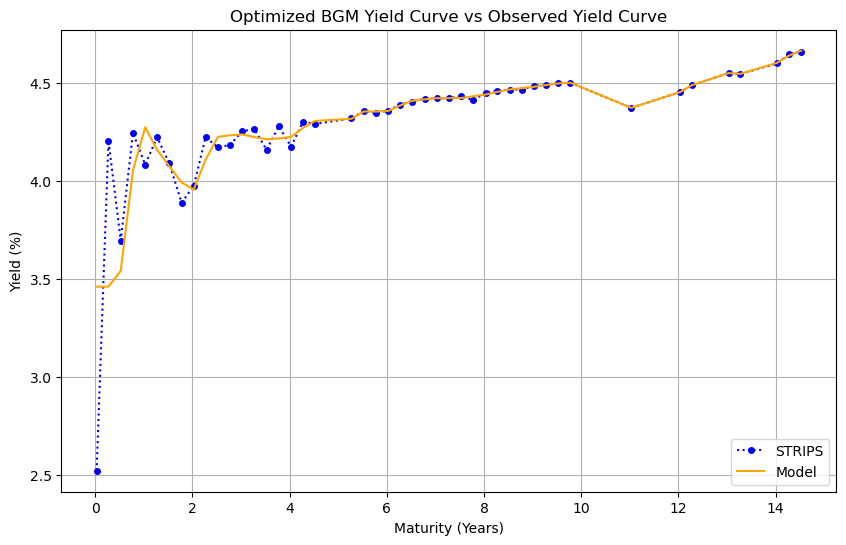

In [42]:
# Fit the model by optimizing forward rates
x0 = initial_forwards  # Start with the initial forward rates
fitter = Fitter(bgm, yields, maturities, 'Q')
fit_result = fitter.fit(x0)
print("Optimized forward rates:", fit_result.x)
print("R-squared:", fitter.r_squared())
print("RMSE (%):", fitter.rmse())
print("AIC:", fitter.aic())

# Optimized yield curve plot
optimized_model_yields = fitter.model_yields
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields * 100, label='STRIPS', linestyle='dotted', marker='o', color='blue', markersize=4)
plt.plot(maturities, optimized_model_yields, label='Model', linestyle='solid', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Optimized BGM Yield Curve vs Observed Yield Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Bond Pricing

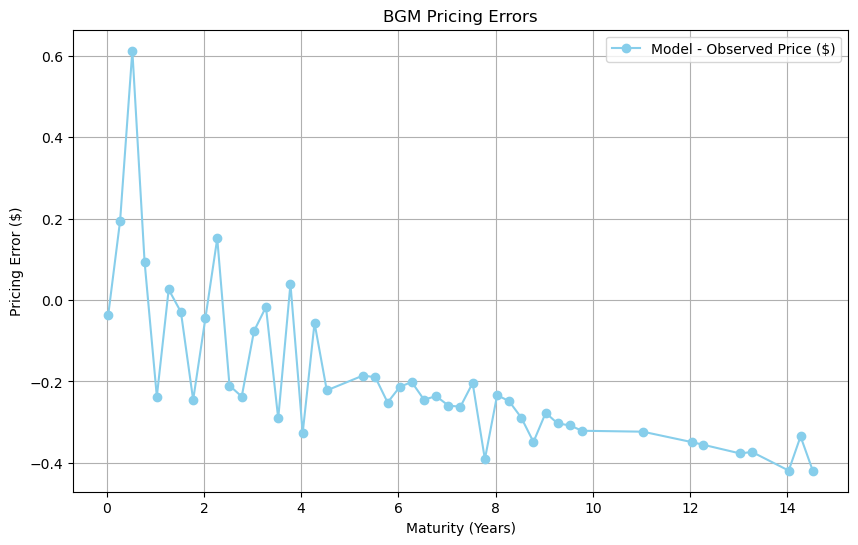

In [44]:
# Step 6: Compute Bond Prices and Pricing Errors
def compute_bond_prices(model, maturities, face_value=100):
    prices = []
    for tau in maturities:
        price = model.zero(0, tau) * face_value
        prices.append(price)
    return np.array(prices)

model_prices = compute_bond_prices(bgm, maturities, face_value)
price_differences = model_prices - observed_prices

plt.figure(figsize=(10, 6))
plt.plot(maturities, price_differences, 'o-', color='skyblue', label='Model - Observed Price ($)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Pricing Error ($)')
plt.title('BGM Pricing Errors')
plt.legend()
plt.grid(True)
plt.show()